In [7]:
# https://www.kaggle.com/zetha82/exercise-word-vectors/edit
# https://www.machinelearningplus.com/nlp/cosine-similarity/
# https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles LDA
import os
import sys
import pandas as pd
import numpy as np
import csv
import re
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
# save numpy array 
from numpy import save
# load numpy array 
from numpy import load
import joblib

!pip install pyldavis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# sklearn knižnice
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation

import scispacy 
from scipy.spatial.distance import jensenshannon

from tqdm import tqdm

cwd = os.getcwd()

# inicializácia mojich funkcií
sys.path.insert(1,cwd + '/insAInDev_Tools/')
import insAInDev_Processor as insAIProc



# inicializácia nlp
# Load the large model to get the vectors
# LINK pre instalaciu https://spacy.io/models/en
nlp = spacy.load("en_core_sci_sm",disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000

def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)] # remove numbers (e.g. from references [1], etc.)



/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_sm' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Načítanie datasetu

In [2]:
# nastavenie vizualizácie full text length
pd.set_option('display.max_colwidth', -1)

# separátor stĺpcov sa používa čiarka (pre tab to je sep='\t')
# quoting=3 je pre odstránenie úvodzoviek v texte 
df = pd.read_csv(cwd + '/Datasets/YelpRatings/yelp_ratings.csv')

# zobrazenie prvých 3 riadkov 
df.head(3)

/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-2-1a240441b50f>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Review,Stars,Sentiment
0,Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.,1.0,0
1,"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon! I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level! \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit. Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room. Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure. That was superb! Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen. The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement. It was so much fun to be there! \n\nNext Travis started with the flat iron. The way he flipped his wrist to get volume all around without over-doing it and making me look like a Texas pagent girl was admirable. It's also worth noting that he didn't fry my hair -- something that I've had happen before with less skilled stylists. At the end of the blowout & style my hair was perfectly bouncey and looked terrific. The only thing better? That this awesome blowout lasted for days! \n\nTravis, I will see you every single time I'm out in Vegas. You make me feel beauuuutiful!",5.0,1
2,"I have to say that this office really has it together, they are so organized and friendly! Dr. J. Phillipp is a great dentist, very friendly and professional. The dental assistants that helped in my procedure were amazing, Jewel and Bailey helped me to feel comfortable! I don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which I knew nothing about before this visit! I highly recommend this office for the nice synergy the whole office has!",5.0,1


### Konkretizácia dát

In [3]:
# pomenovanie stĺpcov z datasetu
col = ['Review', 'Sentiment']
# pridelenie stĺpcov z dataframeu
df = df[col]
# úprava datasetu (vymazanie riadkov s prázdnym textom)
df = df[pd.notnull(df['Review'])]
# definovanie konkrtétnych stĺpcov z dataframeu
df.columns = ['Review', 'Sentiment']

/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Vizualizácia v grafe

/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


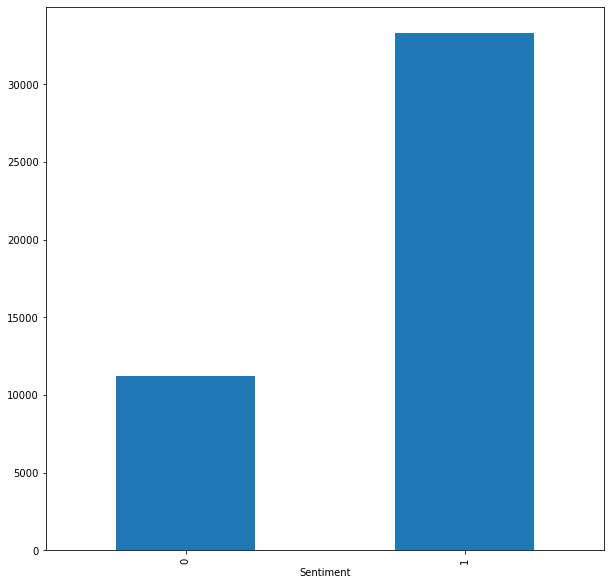

In [4]:
# definovanie veľkosti grafu
fig = plt.figure(figsize=(10,10))

# zoskupenie počtu recenzii rozdelené podľa Liked
df.groupby('Sentiment').Review.count().plot.bar(ylim=0)

# zobrazenie grafu
plt.show()

### Práca so STOPWORDS a Vektorizácia

In [5]:
cleanedCorpus = insAIProc.removeStopwordfromDataframeColumn(df, 'Review','not')

/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Vektorizacia recenzii

In [8]:
tf_vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000) 
tf = tf_vectorizer.fit_transform(tqdm(cleanedCorpus))
tf.shape

/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 44530/44530 [00:13<00:00, 3307.42it/s]


(44530, 34619)

### LDA inicializacia

In [ ]:

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.',
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

### Ulozenie vektorov

In [ ]:
joblib.dump(tf_vectorizer, 'tf_vectorizer.csv')
joblib.dump(tf, 'tf_merge.csv')

### Training modelu LDA

In [ ]:
# this takes long! you can skip this and load the model from the output file
lda_tf = LatentDirichletAllocation(n_components=25, random_state=0) # TODO: tune n_components: how many topics make sense?
lda_tf.fit(tf)
joblib.dump(lda_tf, 'lda_yelp_reviews.csv')

### Discover topics

In [ ]:
tfidf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf, tfidf_feature_names, 25)

### Topic distances

In [ ]:
# topics distance
# slow, load from output file instead
topic_dist = pd.DataFrame(lda_tf.transform(tf))

topic_dist.to_csv('topic_dist.csv', index=False)

# Load from output file
# topic_dist = pd.read_csv(cwd + '/topic_dist.csv')

topic_dist.head()

### Vizualizacia LDA vysledkov

In [ ]:
viz = pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer)
pyLDAvis.display(viz)
pyLDAvis.save_html(viz, 'lda_yelp_reviews.html')

### Get nearest article (in topic space)

In [ ]:
def initiate_k_nearest_articles(docs_dist, k=5):
    
    distances = topic_dist.apply(lambda x: jensenshannon(x, doc_dist), axis=1)

    # inicializacia najblizsich vzdialenosti
    k_nearest = distances[distances != 0].nsmallest(n=k).index

    # incializacia vzdialenosti
    k_distances = distances[distances != 0].nsmallest(n=k)
    
    return k_nearest, k_distances

initiate_k_nearest_articles(topic_dist, 5)

### Odporucane recenzie

In [ ]:
def recommendation(paper_id, k=5, only_covid19=False, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''
    
    print(df_biorvix.title[df_biorvix.paper_id == paper_id].values[0])

    recommended, dist = get_k_nearest_docs2(topic_dist[df_biorvix.paper_id == paper_id].iloc[0], k, only_covid19, get_dist=True)
    recommended = df_biorvix.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    #print(recommended.info())
    
    #h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['link','title', 'similarity']].values])
    h = '<br/>'.join(['<a href=' + str(l) + '" target="_blank">'+ str(n) +'</a>' for l,n in recommended[['paper_id','title']].values])
  
    
    display(HTML(h))